In [5]:
import pandas as pd
import numpy as np
import gmplot
import folium
import json
import datetime
import matplotlib.pyplot as plt
import geopy.distance
import difflib

Open the data

In [7]:
df = pd.read_csv('DOHMH_New_York_City_Restaurant_Inspection_Results.csv')
df.head(2)

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,RECORD DATE,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,50083554,MOCANA BAKERY,Manhattan,532,W 145TH ST,10031.0,9176757582,Bakery,10/25/2018,Violations were cited in the following area(s).,...,10/03/2019,Administrative Miscellaneous / Initial Inspection,40.825655,-73.948648,109.0,7.0,22900.0,1061920.0,1.020760e+09,MN04
1,50047631,SUBWAY,Manhattan,111,BROADWAY,10006.0,2122276323,Sandwiches/Salads/Mixed Buffet,06/25/2018,Violations were cited in the following area(s).,...,10/03/2019,Cycle Inspection / Re-inspection,40.708479,-74.011113,101.0,1.0,1300.0,1001029.0,1.000490e+09,MN25


 <h1>Evolution of score</h1>

<h3>Create a column with the number of the insepction </h3>
<li>1: last inspection
<li>2: 2nd last inspection
<li>...
<li>n: first inspection on the list</h3>

In [37]:
#transform the date in a datetime format 
def time_nan(x):
    if pd.isnull(x):
        return x
    else:
        return datetime.datetime.strptime(x,'%m/%d/%Y')

df['INSPECTION DATE'] = df['INSPECTION DATE'].apply(lambda x: time_nan(x))
df = df.sort_values('INSPECTION DATE')


def add_numbers_visit(df):
    '''
    input : df with the inspections
    process : finds the number of the inspection for each restaurant (1st inspection, 2nd...)
    output : df with the columns 'Number of visits'
    '''
    #group all the camis (unique id code for restaurant) 
    #and inspection date (several line for the same inspection based on the procedures/violations)
    df['count'] = 1
    camis_groups = df.groupby(['CAMIS','INSPECTION DATE'])['count'].sum().reset_index()
    #reset to 1
    camis_groups['count'] = 1
    #group with a cum sum to have the number of the inspection (1st, 2nd...)
    camis_groups = camis_groups.groupby(['CAMIS','INSPECTION DATE'])['count'].sum().groupby(level=[0]).cumsum().reset_index()
    
    #merge with the dataframe 
    df = df.drop('count', axis = 1)
    df = df.merge(camis_groups, on = ['CAMIS', 'INSPECTION DATE']) 
    
    
    #create the column Number_of_visits: 1 (1st insepection), 2 (2nd insepection), ....
    df['Number_of_visits'] = df['count']
    df = df.drop('count', axis = 1)
    
    return df

df = add_numbers_visit(df)
df.head(2)

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA,Number_of_visits
0,50098527,FLIK INTERNATIONAL CORP.,Brooklyn,63,FLUSHING AVE,11205.0,7043285090,Other,1900-01-01,NaN,...,NaN,40.698013,-73.974986,302.0,33.0,54300.0,3335129.0,3.020230e+09,BK99,1
1,50098691,NaN,Bronx,1511,WILKINSON AVE,10461.0,6463417716,Other,1900-01-01,NaN,...,NaN,40.852781,-73.842656,211.0,13.0,29600.0,2047037.0,2.042190e+09,BX49,1


<h3>Score evolution of the most inspected restaurants </h3>

- plot the score evolution for the most inspected restaurants with at least n visits
- see if there is a positive evolution after several inspections

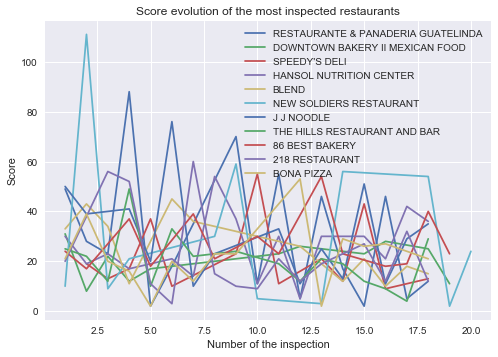

In [46]:
#selection of the restaurant that have been inspected the maximum number of times
n = 17
CAMIS_most_visited = df[df['Number_of_visits']>n]['CAMIS'].unique()
CAMIS_most_visited
grouped_score = df.groupby(["CAMIS","DBA","Number_of_visits","SCORE"]).size().reset_index()
grouped_score

plt.style.use('seaborn')

#for each restaurant, we plot the evolution of the score 
#we use reverse for the left of the graph to be about the first visit and the right about the last
#(number of  visit 1 = last visit, ..., number of visit n = first visit on the dataset)
for cami in CAMIS_most_visited:
    score = list(reversed(list(grouped_score[grouped_score['CAMIS']==cami]['SCORE'])))
    Number_of_visits = list(reversed(list(grouped_score[grouped_score['CAMIS']==cami]['Number_of_visits'])))
    lab = list(grouped_score[grouped_score['CAMIS']==cami]['DBA'])[0]
    plt.plot(Number_of_visits,score,label = lab)

plt.legend()
plt.xlabel('Number of the inspection')
plt.ylabel('Score')
plt.title('Score evolution of the most inspected restaurants')
plt.show()

<h3>Global score evolution over n visits </h3>


In [47]:
#we select the restaurants that have been inspected at least n times and select the last n times 
n = 5
CAMIS_visited_n = df[df['Number_of_visits']>n]['CAMIS'].unique()
number_rest = len(CAMIS_visited_n)
grouped_score = df.groupby(["CAMIS","DBA","Number_of_visits","SCORE"]).size().reset_index()
grouped_score['CAMIS_visited_n'] = grouped_score['CAMIS'].apply(lambda x: x in CAMIS_visited_n)
grouped_score = grouped_score[grouped_score['CAMIS_visited_n']]
grouped_score = grouped_score[grouped_score['Number_of_visits']<=n]

Text(0.5, 1.0, 'Mean on 10038 restaurants')

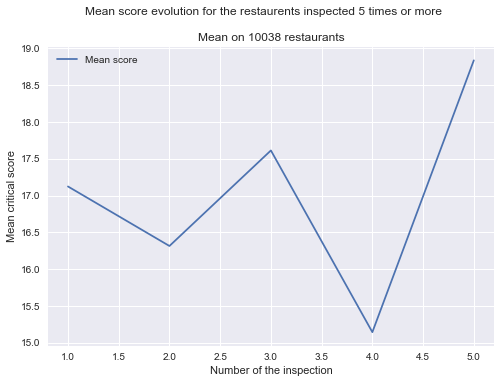

In [48]:
#we calculate the mean score for the last visit, the one before, ...  and the one before
mean_score = []
for i in range(1,n+1):
    mean_score.append(grouped_score[grouped_score['Number_of_visits']==i]['SCORE'].mean())

#we use reverse for the left of the graph to be about the first visit and the right about the last
#(number of  visit 1 = last visit, ..., number of visit n = first visit on the dataset)
mean_score = list(reversed(mean_score))

#we plot the result 
plt.style.use('seaborn')
plt.plot(list(range(1,n+1)),mean_score, label= 'Mean score')
plt.legend()
plt.xlabel('Number of the inspection')
plt.ylabel('Mean critical score')
plt.suptitle('Mean score evolution for the restaurents inspected '+str(n)+' times or more')
plt.title('Mean on '+str(number_rest)+' restaurants')



Text(0.5, 1.0, 'Mean on 10038 restaurants')

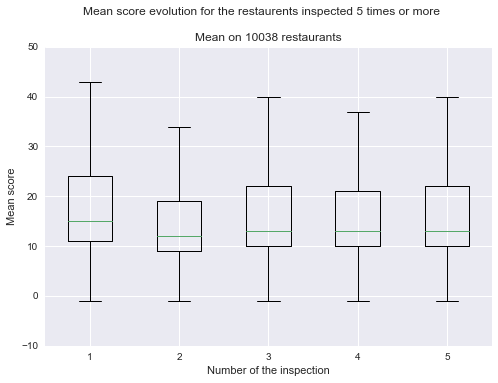

In [49]:
#in form of boxplot
data = []
mean_score = []
for i in range(1,n+1):
    data.append(grouped_score[grouped_score['Number_of_visits']==i]['SCORE'])


plt.boxplot(data)
plt.xlabel('Number of the inspection')
plt.ylabel('Mean score')
plt.ylim((-10, 50)) 
plt.suptitle('Mean score evolution for the restaurents inspected '+str(n)+' times or more')
plt.title('Mean on '+str(number_rest)+' restaurants')


<h1>Mapping</h1>

<h3>Generate map with violation (percentage of B, C and Z last grades)</h3>

In [50]:
#Extract the last grade for the restaurants
sizes = df[df['Number_of_visits']==1.0].groupby(["ZIPCODE","CAMIS","GRADE"]).size().reset_index()
sizes.rename(columns={0:"size"},inplace=True)
#Extract only one grade per restaurant 
sizes['size'] = sizes['size'].apply(lambda x: 1)
sizes = sizes.groupby(["ZIPCODE","GRADE"]).size().reset_index()
sizes.rename(columns={0:"size"},inplace=True)
sizes.head(5)

,ZIPCODE,GRADE,size
0,10000.0,A,1
1,10001.0,A,261
2,10001.0,B,2
3,10001.0,N,5
4,10002.0,A,192


In [56]:
def percentage_violation(zipcode,sizes):
    '''
    process :
    - figure out the number of restaurants with A, B, C, P and Z grades
    - a restaurant is in violation if the grade is not A
    - compute the % of restaurants in violation
    '''
    
    if len(sizes[(sizes["ZIPCODE"]==zipcode)])==0:
        return 0
    else:
        try :
            a = int(sizes[(sizes["ZIPCODE"]==zipcode) & (sizes["GRADE"]=='A')]['size'])
        except:
            a = 0
        try :
            b = int(sizes[(sizes["ZIPCODE"]==zipcode) & (sizes["GRADE"]=='B')]['size'])
        except:
            b = 0
        try :
            c = int(sizes[(sizes["ZIPCODE"]==zipcode) & (sizes["GRADE"]=='C')]['size'])
        except:
            c = 0
        try :
            p = int(sizes[(sizes["ZIPCODE"]==zipcode) & (sizes["GRADE"]=='P')]['size'])
        except:
            p = 0
        try :
            z = int(sizes[(sizes["ZIPCODE"]==zipcode) & (sizes["GRADE"]=='Z')]['size'])
        except:
            z = 0
        try :
            n = int(sizes[(sizes["ZIPCODE"]==zipcode) & (sizes["GRADE"]=='Not Yet Graded')]['size'])
        except:
            n = 0
        return ((b+c+p)/(b+c+z+a+n+p)*100)

#Extract the last grade for the restaurants
sizes = df[df['Number_of_visits']==1.0].groupby(["ZIPCODE","CAMIS","GRADE"]).size().reset_index()
sizes.rename(columns={0:"size"},inplace=True)
#Extract only one grade per restaurant 
sizes = sizes.drop('size',axis=1)
sizes = sizes.groupby(["ZIPCODE","GRADE"]).size().reset_index()
sizes.rename(columns={0:"size"},inplace=True)

#extract all the zip codes from the jason file of NY
with open('zipcode.geojson') as f:
    data = json.load(f)
List_ZIP = []
for element in data['features']:
    List_ZIP.append(str(element['properties']['postalCode']))
    
df_percentage_violation = pd.DataFrame()
df_percentage_violation["ZIPCODE"] = List_ZIP
df_percentage_violation["Percentage_Violation"] = df_percentage_violation["ZIPCODE"].apply(lambda x: percentage_violation(int(x),sizes))
df_percentage_violation["ZIPCODE"] = df_percentage_violation["ZIPCODE"].apply(lambda x: str(int(x)))


df_percentage_violation.describe()

,Percentage_Violation
count,262.000000
mean,1.685250
std,6.534668
min,0.000000
25%,0.000000
50%,0.000000
75%,1.900270
max,100.000000


Plot a map of the results

In [80]:
m = folium.Map(location = [40.7589,-73.9851],zoom_start=12)

m.choropleth(geo_data='zipcode.geojson', data=df_percentage_violation,
             columns=[ "ZIPCODE","Percentage_Violation"],
             key_on='feature.properties.postalCode',
             fill_color='RdYlGn_r', fill_opacity=0.7, line_opacity=0.8,
             legend_name='Percentage of B, C and Z grades',
             threshold_scale=[0,1,2,3,4,7.5,12.5,15,20,100])
folium.LayerControl().add_to(m)
m
#description of the worst 

<h3>Generate map with mean restaurant last grade</h3>

In [63]:
def mean_score(zipcode,sizes):
    L = np.array(sizes[sizes['ZIPCODE']==zipcode]['SCORE'])
    if len(L)==0:
        return 0
    else:
        return L.mean()

In [66]:
#Extract the last score for the restaurants
sizes = df[df['Number_of_visits']==1.0].groupby(["ZIPCODE","CAMIS","SCORE"]).size().reset_index()
sizes.rename(columns={0:"size"},inplace=True)
#Extract only one grade per restaurant 
sizes = sizes.drop('size',axis=1)

#extract all the zip codes from the jason file of NY
with open('zipcode.geojson') as f:
    data = json.load(f)
List_ZIP = []
for element in data['features']:
    List_ZIP.append(str(element['properties']['postalCode']))

df_score = pd.DataFrame()
df_score["ZIPCODE"] = List_ZIP
df_score["Mean_Score"] = df_score["ZIPCODE"].apply(lambda x: mean_score(int(x),sizes))
df_score["ZIPCODE"] = df_score["ZIPCODE"].apply(lambda x: str(int(x)))

df_score.describe()

,Mean_Score
count,262.000000
mean,13.342989
std,6.019464
min,0.000000
25%,12.057350
50%,15.285490
75%,16.863235
max,30.333333


In [81]:
#finish the average score map
m = folium.Map(location = [40.7589,-73.9851],zoom_start=12)

m.choropleth(geo_data='Class 6 - zipcode.geojson', data=df_score,
             columns=[ "ZIPCODE","Mean_Score"],
             key_on='feature.properties.postalCode',
             fill_color='RdYlGn_r', fill_opacity=0.7, line_opacity=0.8,
             legend_name='Mean last score per Zipcode',
             threshold_scale=[0,1,2,3,4,7.5,12.5,15,20,100])
folium.LayerControl().add_to(m)
m